## Hybrid Ice Stream Split

Trying to change the bed geometry to slope in both directions, and include accumulation zone instead of boundary condition.

Import firedrake and set initial conditions.

In [1]:
import firedrake
import icepack
import matplotlib.pyplot as plt
import numpy as np

Lx = 100e3
nx = 72

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

/home/sorenthompson/firedrake/src/ngsPETSc/ngsPETSc/eps.py:10: UserWarning: Import Warning: it was not possible to import SLEPc
  warnings.warn("Import Warning: it was not possible to import SLEPc")
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Set up function spaces for the scalars (Q) and vectors (V) for the 2D mesh.

In [2]:
Q = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="R", vdegree=0)
V = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="GL", vdegree=2)

Import a couple constant values from icepack.

In [3]:
from icepack.constants import(
    ice_density as rho_ice,           # ρ_I | 9.21e-19
    water_density as rho_water,       # ρ_W | 1.03e-18
    weertman_sliding_law as weertman, # m   | 3.0
    gravity as g,                     # g   | 9.77e15
)

Set up spatial coordinates and parameterize bed and surface geometry.

$\tau_D$ = driving stress

$$
\tau_D = -\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}
$$

where $g = $ gravity

$h_{in} = $ incoming height

$\frac{\delta s}{\delta x}$ = surface slope

In [4]:
from firedrake import max_value, min_value
from firedrake import conditional, eq, ne, le, ge, lt, gt

x, z = firedrake.SpatialCoordinate(mesh)

b_in, b_out = 100, -500
base_x = b_in - (b_in - b_out) * x/Lx
b = firedrake.interpolate(base_x, Q)

s_in, s_out = 850, 0
surface_x = s_in - (s_in - s_out) * x/Lx
s0 = firedrake.interpolate(surface_x, Q)

height_x = s0 - b
h0 = firedrake.interpolate(height_x, Q) # Scalar function space

h_in = s_in - b_in
surface_slope = (s_out - s_in) / Lx # δs_δx
tau_D = -rho_ice * g * h_in * surface_slope # driving stress

Check what the profile looks like.

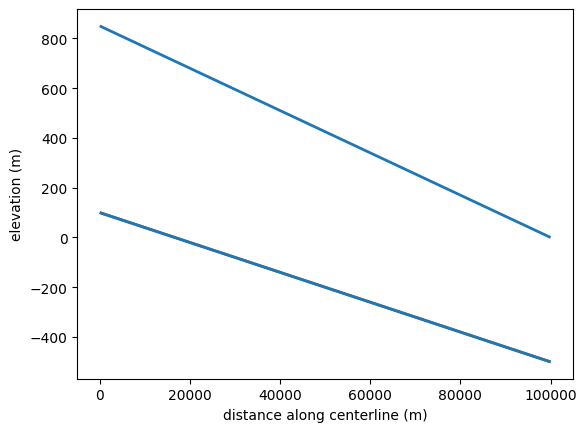

In [5]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb0 = firedrake.interpolate(s0-h0, Q)
firedrake.plot(icepack.depth_average(zb0), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s0), edgecolor="tab:blue", axes = axes);

Estimate intial velocities, increasing exponentially towards the terminus.

$$
u_x = u_{in} + (u_{out} - u_{in}) * \left(\frac{x}{Lx}\right)^2
$$

Just an interpolation between $u_{in}$ and $u_{out}$ using a square.

In [6]:
u_in, u_out = 20, 2400
velocity_x = u_in + (u_out - u_in) * (x / Lx)**2
u0 = firedrake.interpolate(velocity_x,V) # Vector function space

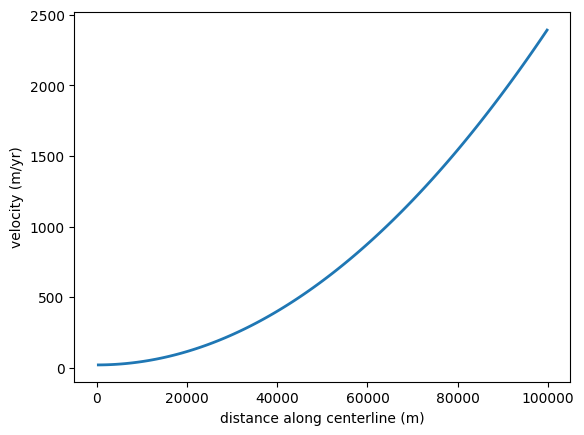

In [7]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")
firedrake.plot(icepack.depth_average(u0), edgecolor="tab:blue", axes=axes);

Set up icepack values.

water pressure = water density * gravity * amount of ice under the water line (elevation = 0)
ice pressure = ice density * gravity * ice height
phi = ramping function for friction.
- If no water pressure, then phi = 1.
- If ice pressure equals water pressure, then phi = 0.

$C$ = Friction Coeff

$$
C = (0.95 - 0.05 \frac{x}{Lx}) \times \frac{\tau_D}{u_{in}^{1/3}}
$$

where $\tau_D =$ driving stress
and $u_{in} = $ incoming velocity at source

Expanding the driving stress, this is

$$
C = -\left(0.95 - 0.05 \frac{x}{Lx}\right) \times \frac{\rho_{ice} \times g \times h_{in} \times \frac{\delta s}{\delta x}}{u_{in}^{1/3}}
$$

$C$ decreases slightly along length, then is a ratio of driving stress and incoming velocity

In [8]:
Temperature = firedrake.Constant(255.0) # -18 deg C
A = icepack.rate_factor(Temperature) # flow rate factor

C = firedrake.interpolate((0.95 - 0.05 * x/Lx) * tau_D / u_in ** (1/weertman), Q) # Friction Coeff

$\phi$ = relative pressure at that point

$p_w =$ upward pressure of submerged ice

$p_I = $ downward pressure of unsubmerged ice

In [9]:
p_water = rho_water * g * max_value(0, h0 - s0) # Prevents negative thickness
p_ice = rho_ice * g * h0
phi = 1 - p_water / p_ice # Are there issues if phi = 0?

#### Weertman friction
The law defines the driving stress as

$$
\tau_b = -C|u|^{\frac{1}{m}-1}u
$$

And the energy dissipation is

$$
E(u) = \int \frac{m}{m + 1}C|u|^{\frac{1}{m} + 1}dx.
$$

Weertman is already implemented in Icepack in the `icepack.models.hybrid.bed_friction(velocity = u, friction = C*phi)` function below.

#### Schoof friction approximation

This is implemented in the Synthetic Flowline Ice Stream tutorial as an approximation of the Schoof sliding law. When the velocity is small, energy dissipation acts relative to $|u|^1$, and when it is large, it acts relative to $|u|^{\frac{1}{m}+1}$. The factor $-U_0$ means that there is no flow when there is no energy dissipation.

$$
E(u) = \int \tau_0 \left( \left( U_0^{\frac{1}{m}+1}+|u|^{\frac{1}{m}+1}\right)^{\frac{m}{m+1}} - U_0 \right) dx
$$

In the implementation, $\tau_0$ is

$$
\tau_0 = C \left( U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}}\right)^{\frac{1}{m+1}}
$$

$\phi$ is implemented the same as above, where the amount of water displaced is the height of ice submerged $h_{sub} = h-s$

$$
\phi = 1 - \frac{\rho_{water}}{\rho_{ice}} \frac{(h_{sub})}{h_{supra}}
$$

Finally, friction is calculated as

$$
\tau_0 \times \phi \times \left(\left(U_0^{\frac{1}{m+1}} + U^{\frac{1}{m+1}} \right)^{\frac{1}{m+1}} - U_0 \right)
$$

#### True Scoof friction

For a truer implementation of schoof friction, the driving stress is 

$$
\tau_b = -C \left(\frac{|u|}{|u|+u_c}\right)^{\frac{1}{m}}\frac{u}{|u|}
$$

In [12]:
from firedrake import sqrt, inner

U_0 = firedrake.Constant(50) 
U = sqrt(inner(u0, u0)) # Sqrt of dot product, a way to get the magnitude of u
tau_0 = firedrake.interpolate(
    C*( U_0**(1/weertman+1) + U**(1/weertman+1) )**(1/(weertman+1)), Q
)

In [14]:
import icepack.models.hybrid

## Weertman friction
def weertman_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice
    
    return icepack.models.hybrid.bed_friction(
        velocity = u,
        friction = C * phi,
    )

def schoof_approx_friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]
    
    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    phi = 1 - p_water/p_ice

    U = sqrt(inner(u, u))
    return tau_0 * phi * (
        (U_0**(1/weertman+1) + U**(1/weertman+1))**(weertman/(weertman+1))-U_0
    )

Set up hybrid model solver with custom friction function and initialize the velocity field.

In [16]:
model = icepack.models.HybridModel(friction = schoof_approx_friction)
opts = {
    "dirichlet_ids": [1],
    #"diagnostic_solver_type": "petsc",
    #"diagnostic_solver_parameters": {"snes_type": "newtontr"},
}

solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity = u0,
    thickness = h0,
    surface = s0,
    fluidity = A,
    friction = C,
)

Plot new initial velocities.

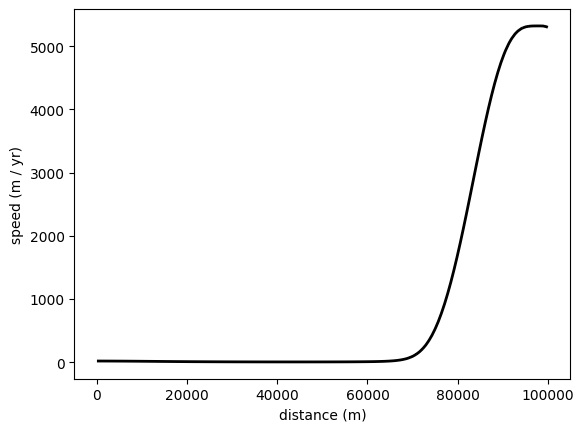

In [17]:
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes);

### Run the actual model

In [18]:
h_min = 10
h_calving = 50
cal_step = h_calving - h_min


In [19]:
import tqdm

num_years = 250
timesteps_per_year = 2

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q) # Ramping accumulation along length
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)

height_min1 = np.zeros(num_timesteps) * np.nan
height_min2 = np.zeros(num_timesteps) * np.nan

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness = h,
        velocity = u,
        accumulation = a,
        thickness_inflow = h0,
    )

    height_min1[step] = h.dat.data_ro.min()

    h = icepack.interpolate(conditional(lt(h,h_calving),h_min,h),Q) # Calving to minimum stable value (use UFL for functions)

    # smooth_h = icepack.interpolate(1-(h-h_min)/cal_step,Q)
    # h = icepack.interpolate(conditional(lt(h,h_calving),(3*smooth_h**2-2*smooth_h**3)*cal_step+h_min,h),Q)
    # h = icepack.interpolate(max_value(h,h_min),Q) # Minimum value for stability
    
    s = icepack.compute_surface(thickness=h, bed=b)

    u = solver.diagnostic_solve(
        velocity = u,
        thickness = h,
        surface = s,
        fluidity = A,
        friction = C,
    )

    height_min2[step] = h.dat.data_ro.min()

100%|████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.99it/s]


Plot profile.

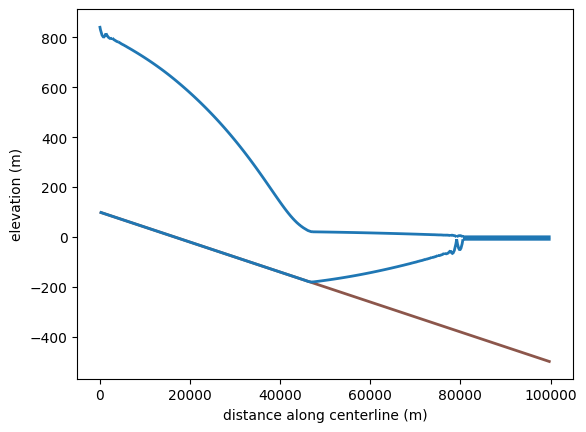

In [20]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(s-h, Q)
firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s), edgecolor="tab:blue", axes = axes);

In [ ]:
# fig, axes = plt.subplots()
# axes.set_xlabel("distance along centerline (m)")
# axes.set_ylabel("smoothstep function")
# firedrake.plot(icepack.depth_average(smooth_h), edgecolor="tab:blue", axes = axes);

In [ ]:
print(height_min1)

In [ ]:
print(height_min2)